In [20]:
#/content/sample_data/Filtered_DataVCp_All_Columns.xlsx
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Загрузка данных
data = pd.read_excel('/content/sample_data/Filtered_DataVCp_All_Columns.xlsx')
temperature = data['T,K'].values
heat_capacity = data['Cp,J/mol-1K-1'].values

heat_capacity = temperature[temperature>10]
temperature = temperature[temperature>10]

In [21]:
data = np.nan_to_num(data, nan=0, posinf=1e6, neginf=-1e6)

In [4]:
!pip install pymc

In [5]:
import pymc as pm

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.11/dist-pac

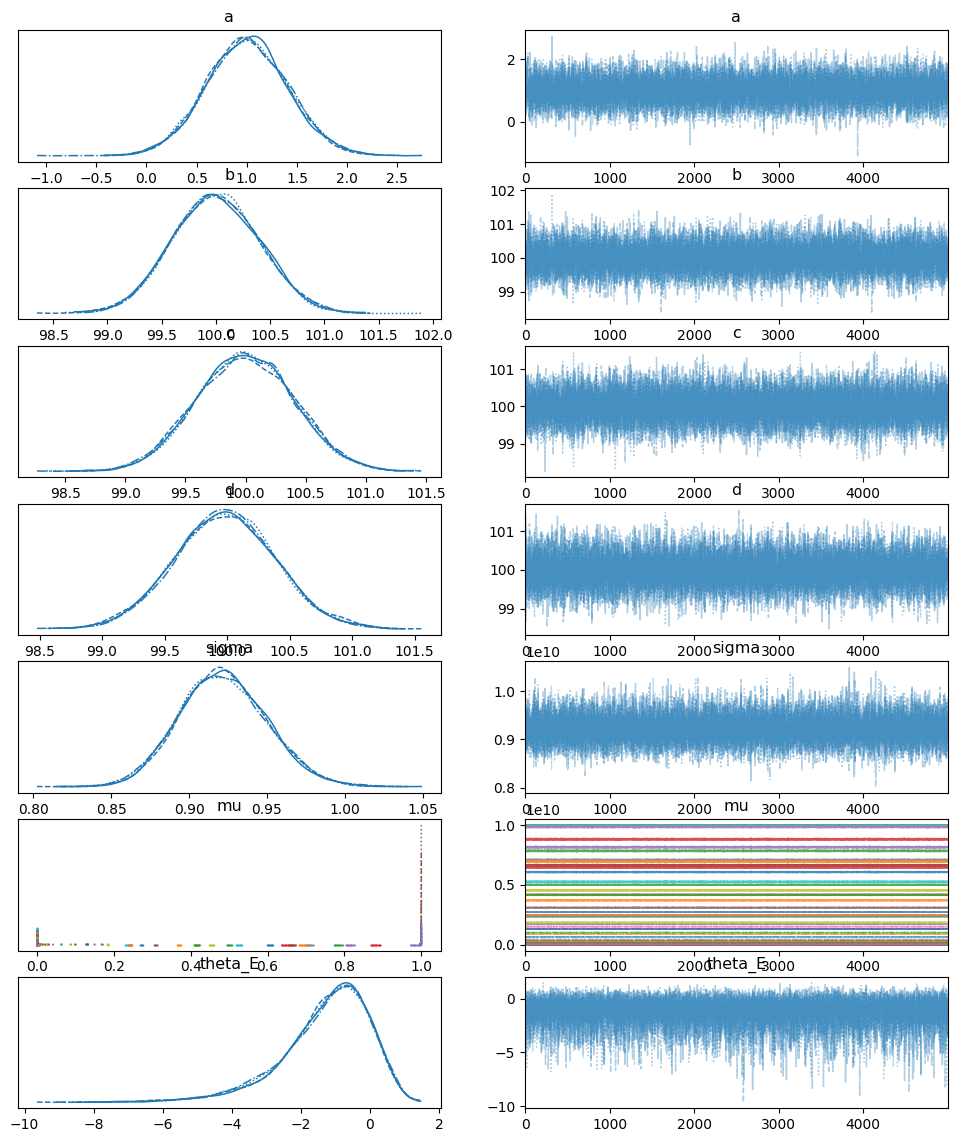

In [66]:
with pm.Model() as model:
    # Априорные распределения
    z = pm.Gamma('z', alpha=1, beta=2)
    theta_E = pm.Deterministic('theta_E', pm.math.log(z))

    # Коэффициенты
    a = pm.Normal('a', mu=1, sigma=0.4)
    b = pm.Normal('b', mu=100, sigma=0.4)
    c = pm.Normal('c', mu=100, sigma=0.4)
    d = pm.Normal('d', mu=100, sigma=0.4)

    # Параметр смешения
    sigma = pm.HalfCauchy('sigma', beta=1)

    # Формула Эйнштейна
    z_pow = z ** (1 / temperature)  # z^(1/T)
    term_E = pm.Deterministic('term_E', (pm.math.log(z) / temperature)**2 * z_pow / (z_pow - 1)**2)

    # Ограничение mu, чтобы избежать переполнения
    mu = pm.Deterministic('mu', pm.math.clip(  # Ограничиваем диапазон mu
            3 * 8.314 * term_E + a * temperature + b * temperature**2 + c * temperature**3 + d * temperature**4,
            -1e10, 1e10
)
    )

    # Правдоподобие
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=heat_capacity)

    trace = pm.sample(draws=5000, tune=3000, chains=4, target_accept=0.95, random_seed=42, nuts={'max_treedepth': 12}, init='adapt_diag')

    az.summary(trace)
    az.plot_trace(trace, var_names=['a', 'b', 'c', 'd', 'sigma', 'mu', 'theta_E' ])  # Только ключевые параметры

In [69]:
with model:
    print(idata.posterior.theta_E[1])

<xarray.DataArray 'theta_E' (draw: 2500)> Size: 20kB
array([299.85142994, 299.85142994, 299.85142994, ..., 299.85142994,
       299.85142994, 299.85142994])
Coordinates:
    chain    int64 8B 1
  * draw     (draw) int64 20kB 0 1 2 3 4 5 6 ... 2494 2495 2496 2497 2498 2499
